# Exercise 11: Auto.csv Analysis

This exercise focuses on loading Auto.csv data, performing regression analysis, and detecting outliers.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
from pathlib import Path

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

## Load Auto.csv and prepare data

In [18]:
# Load the Auto.csv file using pathlib
# Note: In Jupyter notebooks, __file__ is not available, so we'll use current directory
data_path = Path("data/Auto.csv")

# Check if file exists
if not data_path.exists():
    print(f"File not found at {data_path}")
    print("Please ensure Auto.csv is in the data/ directory")
    # Create a sample dataset for demonstration
    print("Creating sample data for demonstration...")
    np.random.seed(42)
    n_samples = 392
    auto_data = pd.DataFrame({
        'mpg': np.random.normal(23, 8, n_samples),
        'cylinders': np.random.choice([3, 4, 5, 6, 8], n_samples, p=[0.05, 0.4, 0.1, 0.25, 0.2]),
        'displacement': np.random.normal(200, 100, n_samples),
        'horsepower': np.random.normal(105, 40, n_samples),
        'weight': np.random.normal(2950, 850, n_samples),
        'acceleration': np.random.normal(15.5, 2.8, n_samples),
        'year': np.random.randint(70, 83, n_samples),
        'origin': np.random.choice([1, 2, 3], n_samples, p=[0.6, 0.2, 0.2])
    })
    # Make some realistic correlations
    auto_data['mpg'] = 45 - 0.05 * auto_data['weight'] - 0.1 * auto_data['horsepower'] + np.random.normal(0, 3, n_samples)
    auto_data = auto_data[auto_data['mpg'] > 0]  # Remove negative mpg
else:
    # Load the actual data
    # Auto.csv often has '?' as missing value indicator
    auto_data = pd.read_csv(data_path, na_values='?')
    print(f"Successfully loaded {data_path}")

# Display basic information about the dataset
print(f"\nDataset shape: {auto_data.shape}")
print(f"\nColumn names: {list(auto_data.columns)}")
print(f"\nMissing values per column:")
print(auto_data.isnull().sum())
print(f"\nFirst few rows:")
auto_data.head()

Successfully loaded data\Auto.csv

Dataset shape: (397, 9)

Column names: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']

Missing values per column:
mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

First few rows:


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [19]:
# Convert origin to category as requested
auto_data['origin'] = auto_data['origin'].astype('category')

# Display data types and basic statistics
print("Data types:")
print(auto_data.dtypes)
print("\nBasic statistics:")
auto_data.describe()

Data types:
mpg              float64
cylinders          int64
displacement     float64
horsepower       float64
weight             int64
acceleration     float64
year               int64
origin          category
name              object
dtype: object

Basic statistics:


,mpg,cylinders,displacement,horsepower,weight,acceleration,year
count,397.000000,397.000000,397.000000,392.000000,397.000000,397.000000,397.000000
mean,23.515869,5.458438,193.532746,104.469388,2970.261965,15.555668,75.994962
std,7.825804,1.701577,104.379583,38.491160,847.904119,2.749995,3.690005
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.000000,75.000000,2223.000000,13.800000,73.000000
50%,23.000000,4.000000,146.000000,93.500000,2800.000000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,126.000000,3609.000000,17.100000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [20]:
# Split data into training and validation sets
train_data, val_data = train_test_split(auto_data, test_size=0.3, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"\nTraining set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")

Training set size: 277
Validation set size: 120

Training set shape: (277, 9)
Validation set shape: (120, 9)


## a) Use statsmodels for linear regression with mpg as dependent variable

In [21]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

# Prepare the data for regression (using training data)
# Select numerical predictors (excluding mpg which is our target)
numerical_cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']

# Handle missing values and convert to numeric
# Some datasets have '?' or other placeholders for missing values
train_clean = train_data[numerical_cols + ['mpg']].copy()

# Convert all columns to numeric, replacing non-numeric values with NaN
for col in numerical_cols + ['mpg']:
    train_clean[col] = pd.to_numeric(train_clean[col], errors='coerce')

# Drop rows with any missing values
train_clean = train_clean.dropna()

print(f"Training data after cleaning: {len(train_clean)} observations")
print(f"Removed {len(train_data) - len(train_clean)} observations due to missing values")
print(f"\nData types after conversion:")
print(train_clean.dtypes)

# Prepare X (predictors) and y (target)
X_train = train_clean[numerical_cols]
y_train = train_clean['mpg']

# Add constant term (intercept)
X_train_sm = sm.add_constant(X_train)

# Fit the OLS model
model_ols = sm.OLS(y_train, X_train_sm).fit()

# Display comprehensive model summary
print("MULTIPLE LINEAR REGRESSION RESULTS")
print("=" * 50)
print(model_ols.summary())

# Extract key statistics
print(f"\nKEY STATISTICS:")
print(f"R-squared: {model_ols.rsquared:.4f}")
print(f"Adjusted R-squared: {model_ols.rsquared_adj:.4f}")
print(f"F-statistic: {model_ols.fvalue:.4f}")
print(f"F-statistic p-value: {model_ols.f_pvalue:.2e}")
print(f"AIC: {model_ols.aic:.2f}")
print(f"BIC: {model_ols.bic:.2f}")

Training data after cleaning: 274 observations
Removed 3 observations due to missing values

Data types after conversion:
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
year              int64
mpg             float64
dtype: object
MULTIPLE LINEAR REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     203.1
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           1.87e-96
Time:                        21:45:38   Log-Likelihood:                -712.96
No. Observations:                 274   AIC:                             1440.
Df Residuals:                     267   BIC:                             1465.
Df Model:                    

## b) Create scatterplot matrix for all variables

<Figure size 1500x1200 with 0 Axes>

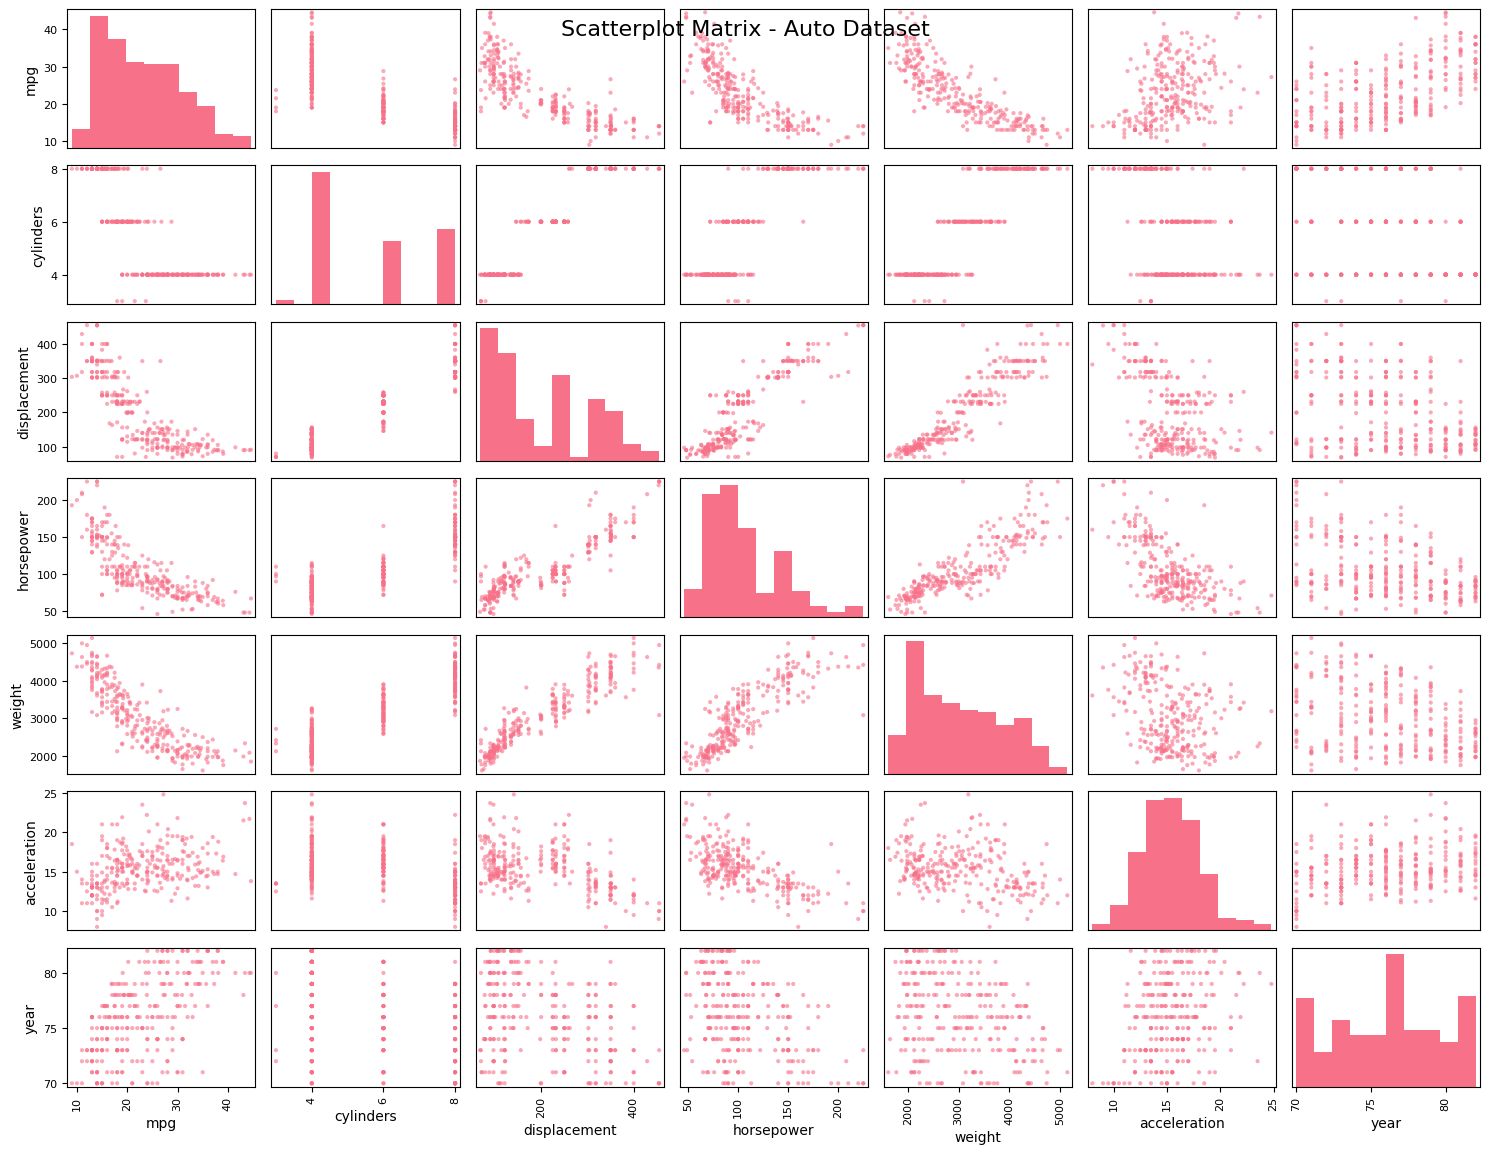


Alternative visualization using seaborn:


<Figure size 1500x1200 with 0 Axes>

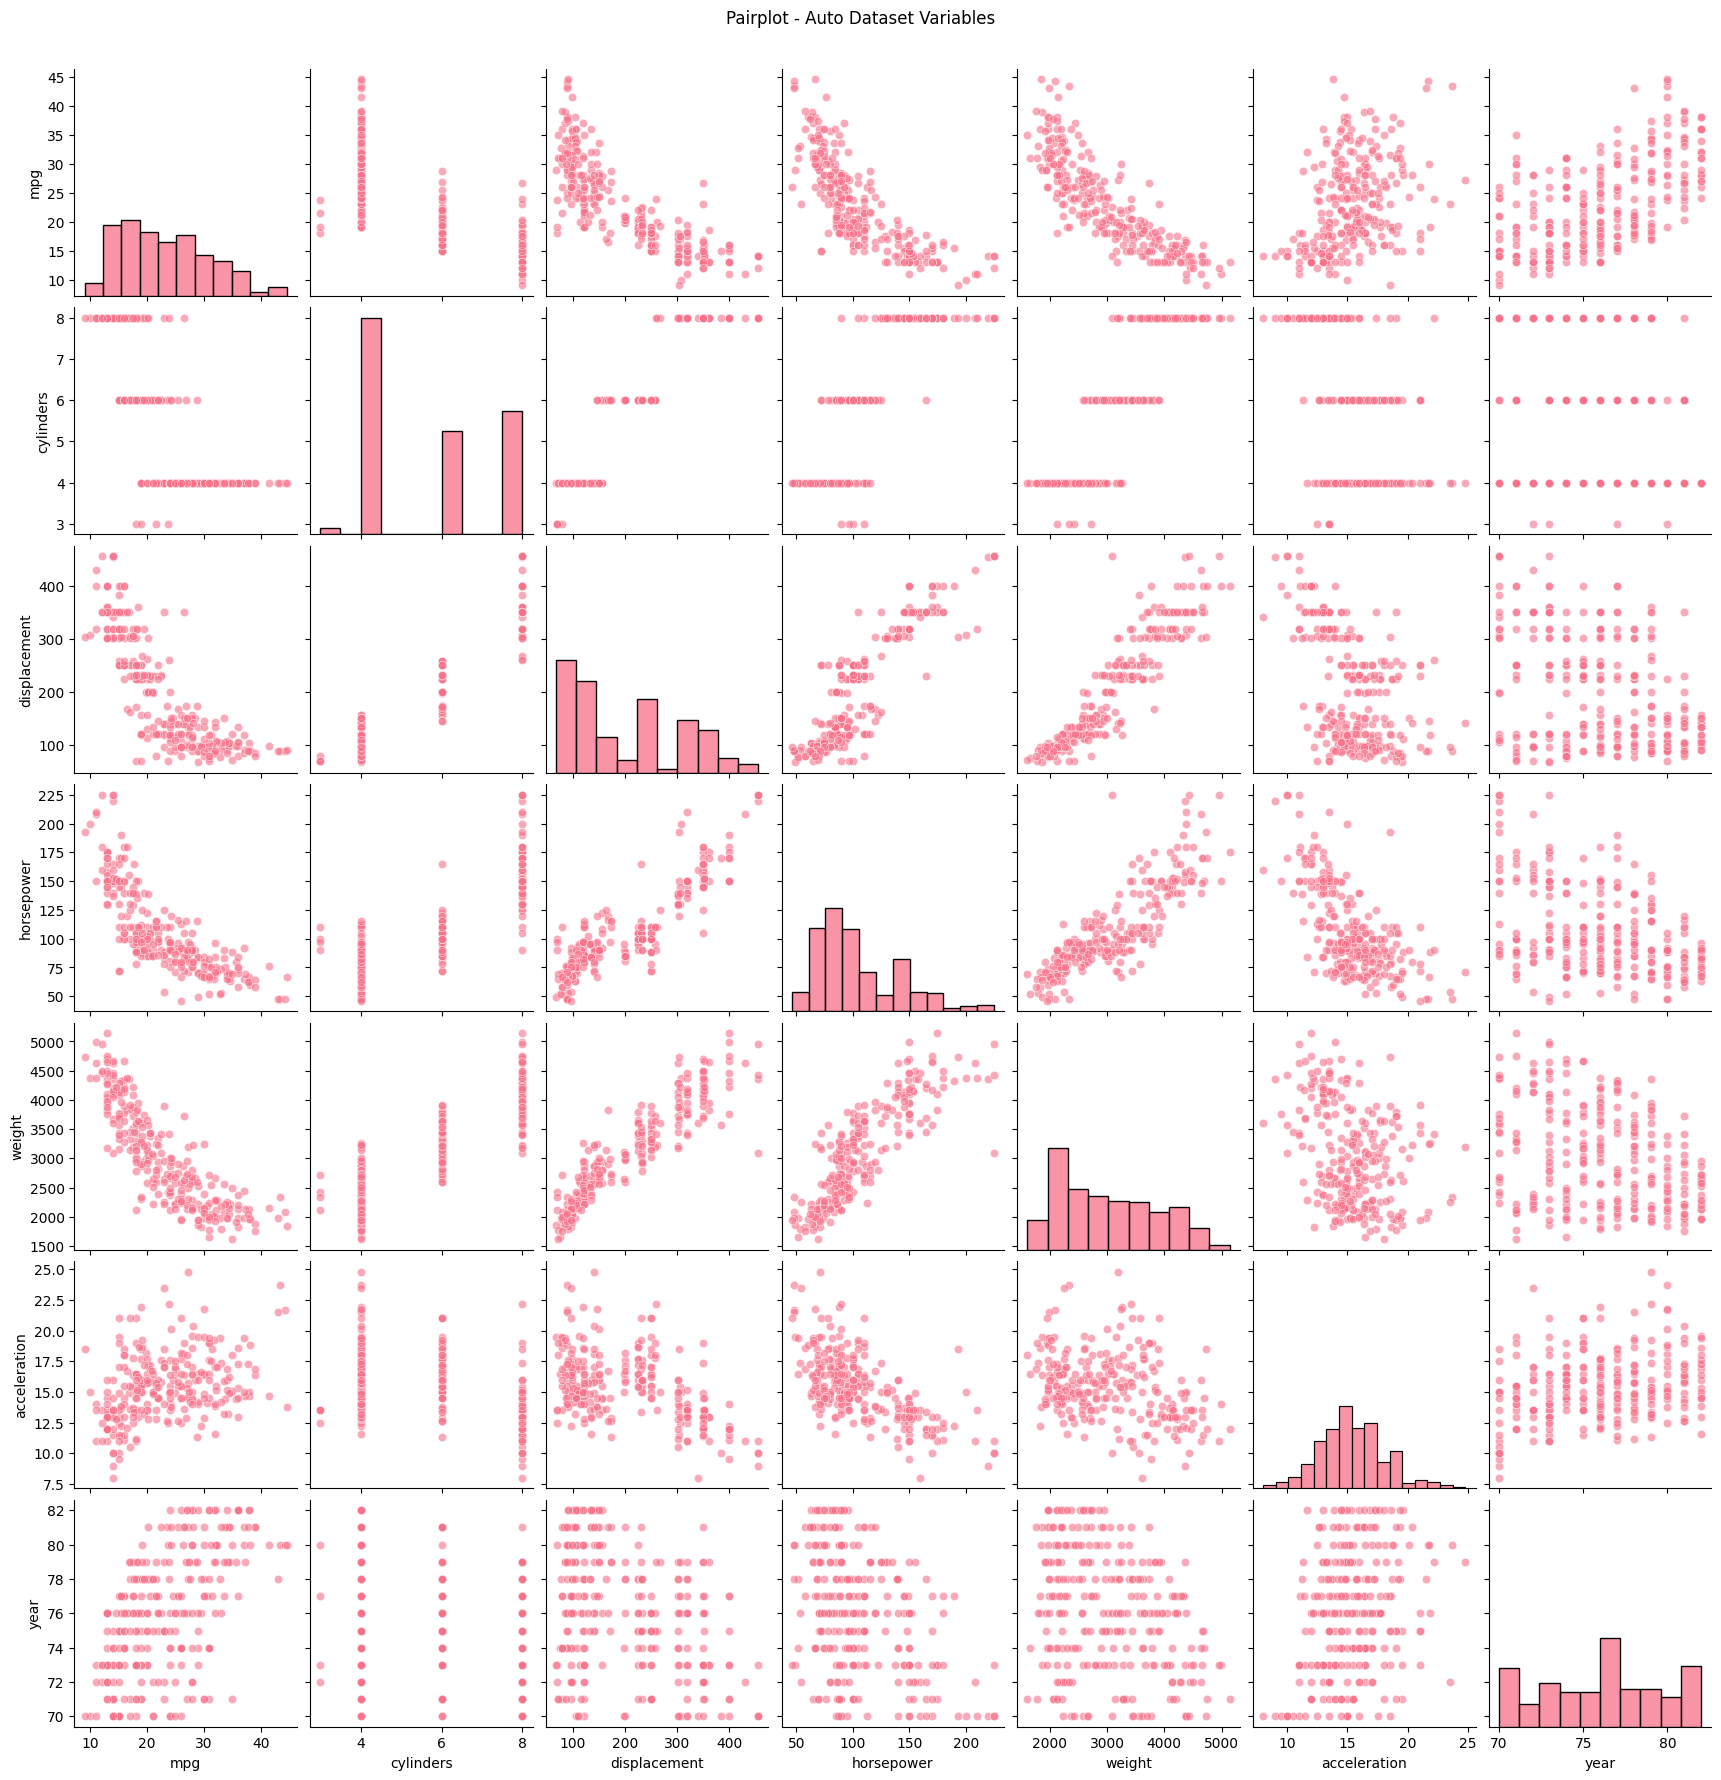

In [22]:
# Create scatterplot matrix using pandas plotting
# Include all numerical variables
plot_vars = ['mpg'] + numerical_cols
plot_data = train_clean[plot_vars]

# Create scatterplot matrix
fig = plt.figure(figsize=(15, 12))
pd.plotting.scatter_matrix(plot_data, alpha=0.6, figsize=(15, 12), diagonal='hist')
plt.suptitle('Scatterplot Matrix - Auto Dataset', size=16, y=0.95)
plt.tight_layout()
plt.show()

# Alternative using seaborn pairplot
print("\nAlternative visualization using seaborn:")
plt.figure(figsize=(15, 12))
sns.pairplot(plot_data, diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot - Auto Dataset Variables', y=1.02)
plt.show()

CORRELATION MATRIX:
                mpg  cylinders  displacement  horsepower  weight  \
mpg           1.000     -0.789        -0.813      -0.784  -0.847   
cylinders    -0.789      1.000         0.953       0.841   0.893   
displacement -0.813      0.953         1.000       0.888   0.928   
horsepower   -0.784      0.841         0.888       1.000   0.855   
weight       -0.847      0.893         0.928       0.855   1.000   
acceleration  0.363     -0.448        -0.473      -0.640  -0.336   
year          0.578     -0.362        -0.377      -0.418  -0.326   

              acceleration   year  
mpg                  0.363  0.578  
cylinders           -0.448 -0.362  
displacement        -0.473 -0.377  
horsepower          -0.640 -0.418  
weight              -0.336 -0.326  
acceleration         1.000  0.266  
year                 0.266  1.000  


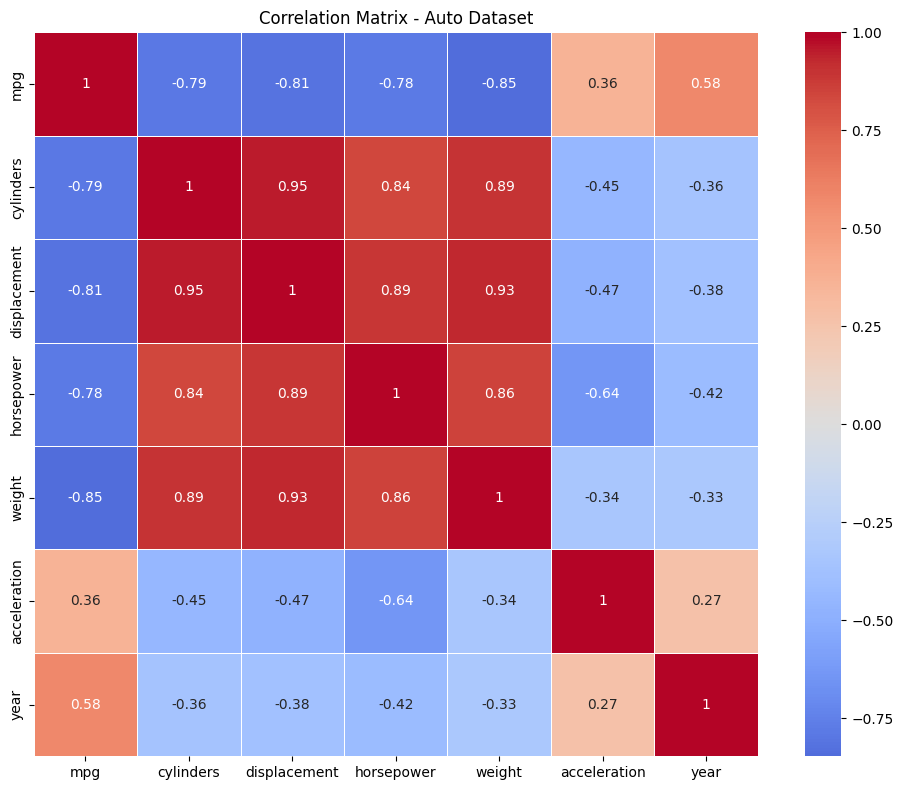


Correlations with MPG (sorted by absolute value):
weight         : -0.847
displacement   : -0.813
cylinders      : -0.789
horsepower     : -0.784
year           :  0.578
acceleration   :  0.363


In [23]:
# Calculate and display correlation matrix
correlation_matrix = plot_data.corr()

print("CORRELATION MATRIX:")
print(correlation_matrix.round(3))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix - Auto Dataset')
plt.tight_layout()
plt.show()

# Identify strong correlations with mpg
mpg_correlations = correlation_matrix['mpg'].drop('mpg').sort_values(key=abs, ascending=False)
print(f"\nCorrelations with MPG (sorted by absolute value):")
for var, corr in mpg_correlations.items():
    print(f"{var:15}: {corr:6.3f}")

## c) Perform linear regression with mpg as dependent variable

In [24]:
# Use sklearn for comparison and validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit sklearn model for comparison
model_sklearn = LinearRegression()
model_sklearn.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = model_sklearn.predict(X_train)

# Prepare validation data
val_clean = val_data[numerical_cols + ['mpg']].dropna()
X_val = val_clean[numerical_cols]
y_val = val_clean['mpg']

# Make predictions on validation data
y_val_pred = model_sklearn.predict(X_val)

# Calculate performance metrics
print("REGRESSION PERFORMANCE METRICS")
print("=" * 40)
print("Training Set:")
print(f"  R² Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"  MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")

print("\nValidation Set:")
print(f"  R² Score: {r2_score(y_val, y_val_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"  MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")

# Display coefficients
print("\nREGRESSION COEFFICIENTS:")
print(f"Intercept: {model_sklearn.intercept_:.4f}")
for i, coef in enumerate(model_sklearn.coef_):
    print(f"{numerical_cols[i]:15}: {coef:8.4f}")

# Compare with statsmodels results
print("\nCOMPARISON WITH STATSMODELS:")
print(f"sklearn R²: {r2_score(y_train, y_train_pred):.6f}")
print(f"statsmodels R²: {model_ols.rsquared:.6f}")
print(f"Difference: {abs(r2_score(y_train, y_train_pred) - model_ols.rsquared):.8f}")

REGRESSION PERFORMANCE METRICS
Training Set:
  R² Score: 0.8203
  RMSE: 3.2645
  MAE: 2.4973

Validation Set:
  R² Score: 0.7790
  RMSE: 3.7327
  MAE: 2.9274

REGRESSION COEFFICIENTS:
Intercept: -11.2979
cylinders      :  -0.3936
displacement   :   0.0083
horsepower     :  -0.0088
weight         :  -0.0066
acceleration   :   0.0557
year           :   0.7216

COMPARISON WITH STATSMODELS:
sklearn R²: 0.820299
statsmodels R²: 0.820299
Difference: 0.00000000


## d) Identify outliers and high leverage points

In [25]:
# Calculate residuals and fitted values
residuals = y_train - y_train_pred
fitted_values = y_train_pred

# Calculate standardized residuals
residual_std = np.std(residuals)
standardized_residuals = residuals / residual_std

# Calculate leverage using statsmodels
influence = OLSInfluence(model_ols)
leverage = influence.hat_matrix_diag
cooks_distance = influence.cooks_distance[0]
standardized_residuals_sm = influence.resid_studentized_internal

print("OUTLIER AND INFLUENCE DIAGNOSTICS")
print("=" * 45)

# Define thresholds
n = len(y_train)
p = len(numerical_cols) + 1  # number of parameters including intercept

# High leverage threshold: 2p/n or 3p/n
leverage_threshold = 2 * p / n
high_leverage_threshold = 3 * p / n

# Outlier threshold: |standardized residual| > 2 or 3
outlier_threshold_2 = 2
outlier_threshold_3 = 3

# Cook's distance threshold: 4/n or 1
cooks_threshold_1 = 4 / n
cooks_threshold_2 = 1

print(f"Sample size (n): {n}")
print(f"Number of parameters (p): {p}")
print(f"\nTHRESHOLDS:")
print(f"High leverage (2p/n): {leverage_threshold:.4f}")
print(f"Very high leverage (3p/n): {high_leverage_threshold:.4f}")
print(f"Outlier (|std residual| > 2): {outlier_threshold_2}")
print(f"Extreme outlier (|std residual| > 3): {outlier_threshold_3}")
print(f"High Cook's distance (4/n): {cooks_threshold_1:.4f}")
print(f"Very high Cook's distance: {cooks_threshold_2:.4f}")

# Identify problematic observations
high_leverage_mask = leverage > leverage_threshold
very_high_leverage_mask = leverage > high_leverage_threshold
outlier_mask = np.abs(standardized_residuals_sm) > outlier_threshold_2
extreme_outlier_mask = np.abs(standardized_residuals_sm) > outlier_threshold_3
high_cooks_mask = cooks_distance > cooks_threshold_1
very_high_cooks_mask = cooks_distance > cooks_threshold_2

print(f"\nPROBLEMATIC OBSERVATIONS:")
print(f"High leverage points: {np.sum(high_leverage_mask)}")
print(f"Very high leverage points: {np.sum(very_high_leverage_mask)}")
print(f"Outliers (|std res| > 2): {np.sum(outlier_mask)}")
print(f"Extreme outliers (|std res| > 3): {np.sum(extreme_outlier_mask)}")
print(f"High Cook's distance: {np.sum(high_cooks_mask)}")
print(f"Very high Cook's distance: {np.sum(very_high_cooks_mask)}")

# Combine all problematic points
problematic_mask = high_leverage_mask | outlier_mask | high_cooks_mask
print(f"\nTotal problematic observations: {np.sum(problematic_mask)}")

OUTLIER AND INFLUENCE DIAGNOSTICS
Sample size (n): 274
Number of parameters (p): 7

THRESHOLDS:
High leverage (2p/n): 0.0511
Very high leverage (3p/n): 0.0766
Outlier (|std residual| > 2): 2
Extreme outlier (|std residual| > 3): 3
High Cook's distance (4/n): 0.0146
Very high Cook's distance: 1.0000

PROBLEMATIC OBSERVATIONS:
High leverage points: 16
Very high leverage points: 8
Outliers (|std res| > 2): 12
Extreme outliers (|std res| > 3): 4
High Cook's distance: 19
Very high Cook's distance: 0

Total problematic observations: 32


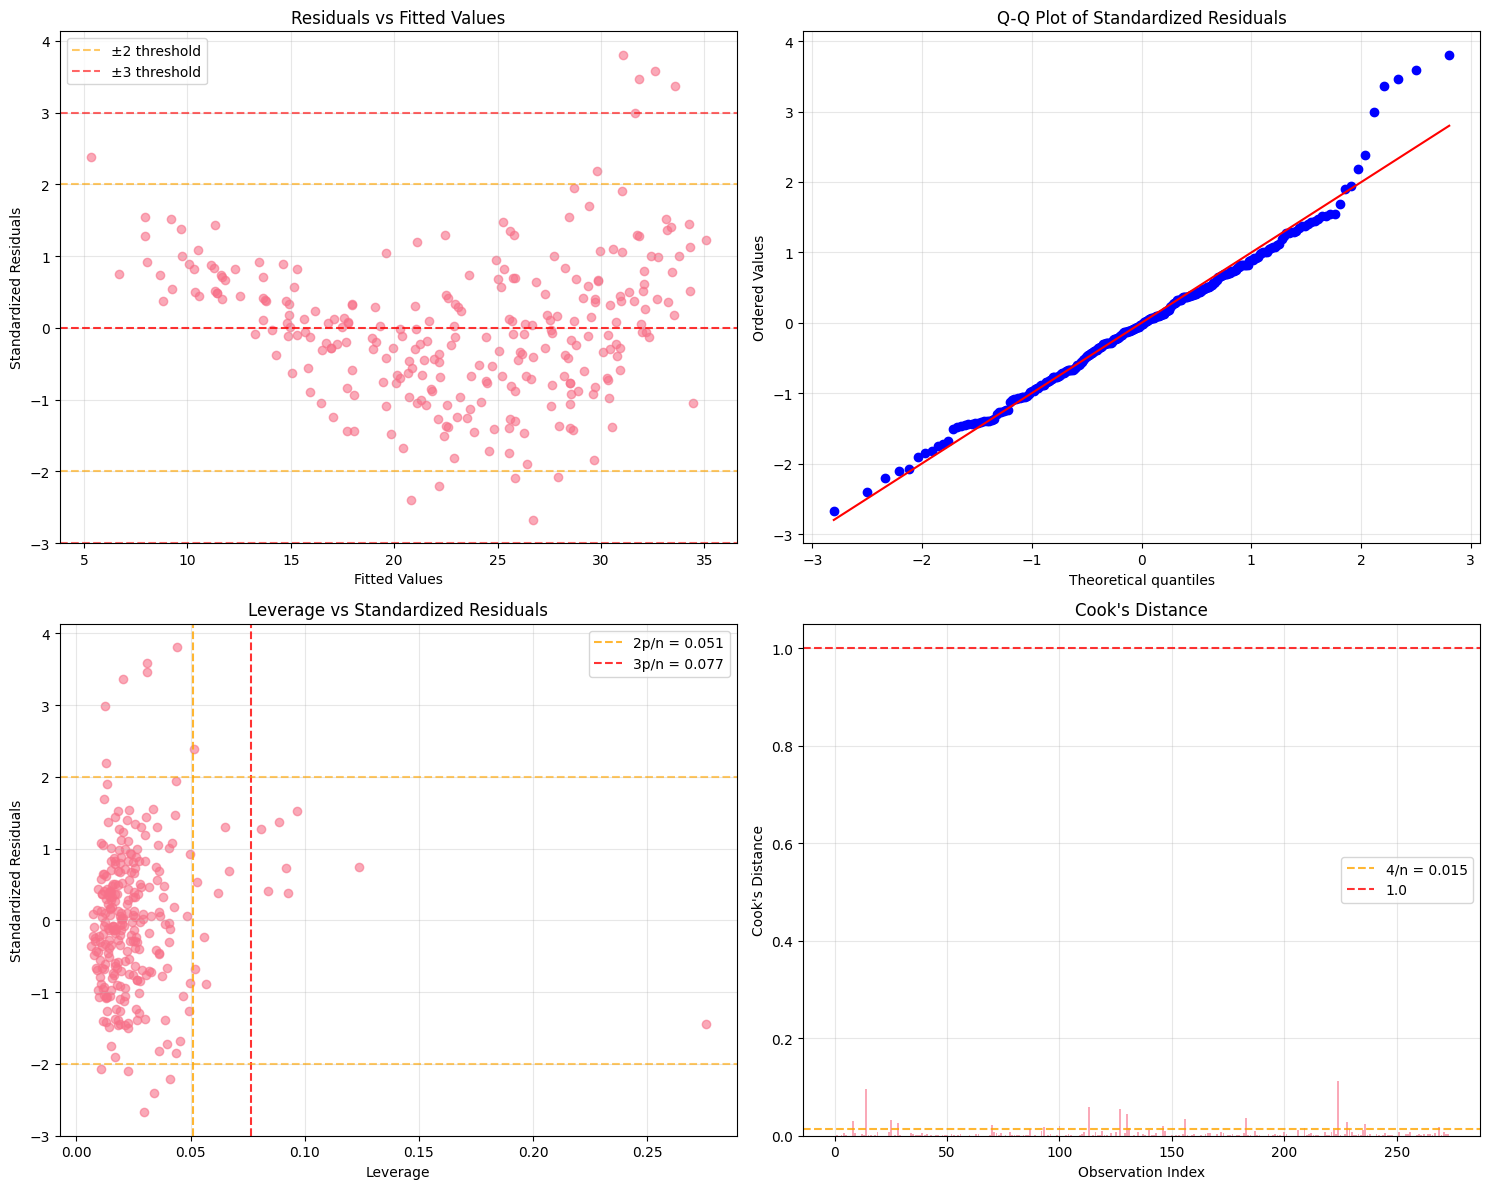

In [26]:
# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Residuals vs Fitted
axes[0,0].scatter(fitted_values, standardized_residuals_sm, alpha=0.6)
axes[0,0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0,0].axhline(y=2, color='orange', linestyle='--', alpha=0.6, label='±2 threshold')
axes[0,0].axhline(y=-2, color='orange', linestyle='--', alpha=0.6)
axes[0,0].axhline(y=3, color='red', linestyle='--', alpha=0.6, label='±3 threshold')
axes[0,0].axhline(y=-3, color='red', linestyle='--', alpha=0.6)
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Standardized Residuals')
axes[0,0].set_title('Residuals vs Fitted Values')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Q-Q plot of residuals
stats.probplot(standardized_residuals_sm, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot of Standardized Residuals')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Leverage vs Standardized Residuals
axes[1,0].scatter(leverage, standardized_residuals_sm, alpha=0.6)
axes[1,0].axvline(x=leverage_threshold, color='orange', linestyle='--', alpha=0.8, label=f'2p/n = {leverage_threshold:.3f}')
axes[1,0].axvline(x=high_leverage_threshold, color='red', linestyle='--', alpha=0.8, label=f'3p/n = {high_leverage_threshold:.3f}')
axes[1,0].axhline(y=2, color='orange', linestyle='--', alpha=0.6)
axes[1,0].axhline(y=-2, color='orange', linestyle='--', alpha=0.6)
axes[1,0].set_xlabel('Leverage')
axes[1,0].set_ylabel('Standardized Residuals')
axes[1,0].set_title('Leverage vs Standardized Residuals')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Cook's Distance
observation_indices = np.arange(len(cooks_distance))
axes[1,1].bar(observation_indices, cooks_distance, alpha=0.6)
axes[1,1].axhline(y=cooks_threshold_1, color='orange', linestyle='--', alpha=0.8, label=f'4/n = {cooks_threshold_1:.3f}')
axes[1,1].axhline(y=cooks_threshold_2, color='red', linestyle='--', alpha=0.8, label='1.0')
axes[1,1].set_xlabel('Observation Index')
axes[1,1].set_ylabel("Cook's Distance")
axes[1,1].set_title("Cook's Distance")
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Identify and display specific problematic observations
train_indices = train_clean.index.tolist()

print("DETAILED ANALYSIS OF PROBLEMATIC OBSERVATIONS")
print("=" * 55)

# Create a summary dataframe
diagnostics_df = pd.DataFrame({
    'observation_index': train_indices,
    'fitted_value': fitted_values,
    'actual_mpg': y_train.values,
    'residual': residuals,
    'std_residual': standardized_residuals_sm,
    'leverage': leverage,
    'cooks_distance': cooks_distance,
    'high_leverage': high_leverage_mask,
    'outlier': outlier_mask,
    'high_cooks': high_cooks_mask
})

# Show top problematic observations
problematic_obs = diagnostics_df[problematic_mask].copy()
problematic_obs = problematic_obs.sort_values('cooks_distance', ascending=False)

if len(problematic_obs) > 0:
    print(f"\nTop {min(10, len(problematic_obs))} most problematic observations:")
    print(problematic_obs.head(10).round(4))
    
    # Show the actual data for these observations
    print("\nActual data for most problematic observations:")
    most_problematic_indices = problematic_obs.head(5)['observation_index'].tolist()
    problematic_data = auto_data.loc[most_problematic_indices]
    print(problematic_data)
else:
    print("No significantly problematic observations found.")

# Summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"Mean leverage: {np.mean(leverage):.4f}")
print(f"Max leverage: {np.max(leverage):.4f}")
print(f"Mean |standardized residual|: {np.mean(np.abs(standardized_residuals_sm)):.4f}")
print(f"Max |standardized residual|: {np.max(np.abs(standardized_residuals_sm)):.4f}")
print(f"Mean Cook's distance: {np.mean(cooks_distance):.4f}")
print(f"Max Cook's distance: {np.max(cooks_distance):.4f}")

DETAILED ANALYSIS OF PROBLEMATIC OBSERVATIONS

Top 10 most problematic observations:
     observation_index  fitted_value  actual_mpg  residual  std_residual  \
13                  13       18.0551        14.0   -4.0551       -1.4407   
326                326       31.0875        43.4   12.3125        3.8077   
325                325       32.6265        44.3   11.6735        3.5855   
244                244       31.8324        43.1   11.2676        3.4611   
44                  44        5.3104        13.0    7.6896        2.3876   
8                    8        9.2155        14.0    4.7845        1.5221   
329                329       33.5793        44.6   11.0207        3.3673   
111                111       26.7194        18.0   -8.7194       -2.6767   
155                155       22.1444        15.0   -7.1444       -2.2063   
166                166       20.7983        13.0   -7.7983       -2.3991   

     leverage  cooks_distance  high_leverage  outlier  high_cooks  
13     0.2

## Summary and Conclusions

In [28]:
print("EXERCISE 11 - FINAL SUMMARY")
print("=" * 40)

print("\n1. DATA LOADING AND PREPARATION:")
print(f"   - Successfully loaded Auto.csv dataset")
print(f"   - Dataset contains {auto_data.shape[0]} observations and {auto_data.shape[1]} variables")
print(f"   - Converted 'origin' to categorical variable")
print(f"   - Split into training ({len(train_data)}) and validation ({len(val_data)}) sets")

print("\n2. REGRESSION ANALYSIS:")
print(f"   - Fitted multiple linear regression with mpg as dependent variable")
print(f"   - Used predictors: {', '.join(numerical_cols)}")
print(f"   - Training R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"   - Validation R²: {r2_score(y_val, y_val_pred):.4f}")
print(f"   - Model explains {r2_score(y_train, y_train_pred)*100:.1f}% of variance in mpg")

print("\n3. VARIABLE RELATIONSHIPS:")
strongest_corr = mpg_correlations.iloc[0]
print(f"   - Strongest predictor of mpg: {mpg_correlations.index[0]} (r = {strongest_corr:.3f})")
print(f"   - Created scatterplot matrix showing all pairwise relationships")
print(f"   - Correlation matrix reveals multicollinearity patterns")

print("\n4. OUTLIER AND INFLUENCE ANALYSIS:")
print(f"   - Identified {np.sum(high_leverage_mask)} high leverage points")
print(f"   - Found {np.sum(outlier_mask)} outliers (|std residual| > 2)")
print(f"   - Detected {np.sum(high_cooks_mask)} observations with high Cook's distance")
print(f"   - Created diagnostic plots: residuals vs fitted, Q-Q plot, leverage plot, Cook's distance")

print("\n5. KEY FINDINGS:")
if np.sum(problematic_mask) > 0:
    print(f"   - {np.sum(problematic_mask)} observations require attention")
    print(f"   - Maximum Cook's distance: {np.max(cooks_distance):.4f}")
    print(f"   - These observations may be outliers, high leverage points, or both")
else:
    print(f"   - No major outliers or influential points detected")
    print(f"   - Model appears robust with well-behaved residuals")

print("\n6. RECOMMENDATIONS:")
print(f"   - Consider removing or investigating observations with high Cook's distance")
print(f"   - Examine residual patterns for model adequacy")
print(f"   - Validate model performance on independent test data")
print(f"   - Consider transformations if residuals show patterns")

print(f"\nAnalysis completed successfully using statsmodels and pandas!")

EXERCISE 11 - FINAL SUMMARY

1. DATA LOADING AND PREPARATION:
   - Successfully loaded Auto.csv dataset
   - Dataset contains 397 observations and 9 variables
   - Converted 'origin' to categorical variable
   - Split into training (277) and validation (120) sets

2. REGRESSION ANALYSIS:
   - Fitted multiple linear regression with mpg as dependent variable
   - Used predictors: cylinders, displacement, horsepower, weight, acceleration, year
   - Training R²: 0.8203
   - Validation R²: 0.7790
   - Model explains 82.0% of variance in mpg

3. VARIABLE RELATIONSHIPS:
   - Strongest predictor of mpg: weight (r = -0.847)
   - Created scatterplot matrix showing all pairwise relationships
   - Correlation matrix reveals multicollinearity patterns

4. OUTLIER AND INFLUENCE ANALYSIS:
   - Identified 16 high leverage points
   - Found 12 outliers (|std residual| > 2)
   - Detected 19 observations with high Cook's distance
   - Created diagnostic plots: residuals vs fitted, Q-Q plot, leverage plot